# Expression Cloning

In [1]:
import igl
import numpy as np

In [2]:
def get_vertex_to_face_map(V, F):
    """
    For each vertex, returns a list of face indices it belongs to.

    Args:
        V (np.ndarray): Vertices array of shape (n, 3)
        F (np.ndarray): Faces array of shape (m, 3)

    Returns:
        vertex_face_map (list of lists): vertex_face_map[i] contains the list of face indices that vertex i belongs to
    """
    num_vertices = V.shape[0]
    vertex_face_map = [[] for _ in range(num_vertices)]

    for face_idx, face in enumerate(F):
        for vertex_idx in face:
            vertex_face_map[vertex_idx].append(face_idx)

    return vertex_face_map

def get_TBN_foreach_vertex(V, F):
    """
    Get TBN matrix for each vertex

    Args:
        V (np.ndarray): vertices (N, 3)
        F (np.ndarray): faces / trianlges (M, 3)

    Returns:
        np.ndarray: matrix (N, 3, 3)
        [
            [Tx, Ty, Tz],
            [Bx, By, Bz],
            [Nx, Ny, Nz],
        ]
    """
    Vn = igl.per_vertex_normals(V, F)
    
    al = igl.adjacency_list(F) # all neighbors
    nb = [nbrs[0] for nbrs in al] # select one

    Vt_nb = V[nb] - V
    Vt_nb = Vt_nb/np.linalg.norm(Vt_nb, axis=1)[:,None]

    # project
    _Vt = np.sum(Vt_nb * Vn, axis=1, keepdims=True)
        
    Vt = (Vt_nb - _Vt * Vn)
    Vt = Vt/np.linalg.norm(Vt, axis=1)[:,None]
    
    Vb = np.cross(Vn, Vt)
    Vb = Vb/np.linalg.norm(Vb, axis=1)[:,None]
    
    return np.concatenate([
        Vt[:,None], 
        Vb[:,None],
        Vn[:,None], 
    ], axis=1)

def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_TriangleArea_foreach_vertex(V,F):
    """
    Returns (V,)
    """
    DArea = igl.doublearea(V, F) * 0.5
    print(DArea.shape)

    V2F = get_vertex_to_face_map(V,F)
    VArea = []
    for v2f in V2F:
        VArea.append(np.sum(DArea[v2f])/len(v2f))
    VArea = np.array(VArea)
    return VArea

def get_scale_foreach_vertex(V,F):
    """
    Returns (V, 3)
    """
    # Vxyz = []
    # for vf in V[F]: # F, 3, 3
    #     Vxyz.append(vf.max(0)-vf.min(0))
    # Vxyz = np.array(Vxyz)
    
    V2F = get_vertex_to_face_map(V,F)
    Vscale = []
    for v2f in V2F:
        Vscale.append(np.std(V[F[v2f]].reshape(-1,3), axis=0))
    Vscale = np.array(Vscale)
    return Vscale

## create mesh set

In [3]:
V, F = igl.read_triangle_mesh("_tmp/m02_model.obj")

newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
## Note that both mesh has same mesh structure! -> F == newF
newV = rescale(newV ,V)

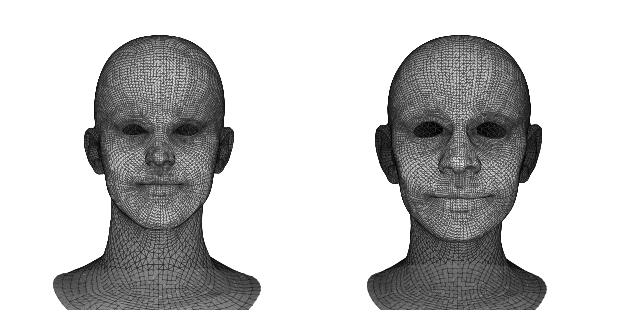

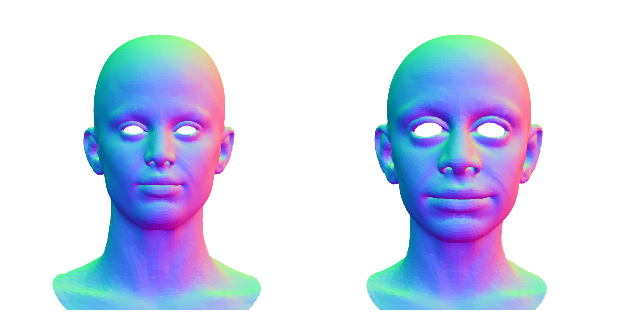

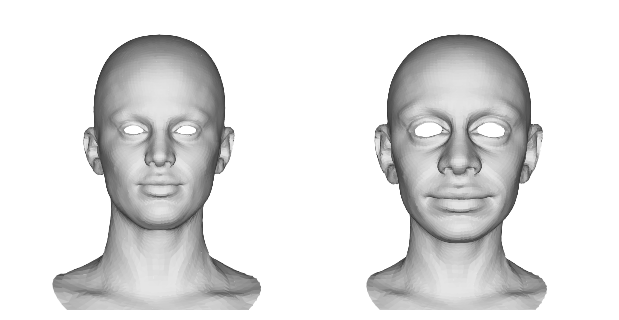

In [4]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.6
# mesh that you wanna render
FRAME=150
v_list=[ V, newV ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

## Get local coordinate system via TBN matrix

In [18]:
V_TBN = get_TBN_foreach_vertex(V, F)
newV_TBN = get_TBN_foreach_vertex(newV, F)

In [86]:
Varea = get_scale_foreach_vertex(V,F)
newVarea = get_scale_foreach_vertex(newV,F)
newS = newVarea/Varea
print(newS.shape)

# from scipy.ndimage import gaussian_filter
# newS = gaussian_filter(newS, 3, mode='nearest')
# newS[:,0] = gaussian_filter1d(newS[:,0], 3,mode='nearest')
# newS[:,1] = gaussian_filter1d(newS[:,1], 3,mode='nearest')
# newS[:,2] = gaussian_filter1d(newS[:,2], 3,mode='nearest')


newS = np.eye(3)[None, :, :] * newS[:, :, None]

(11248, 3)


## Animation for the source mesh

In [41]:
motions = np.load(r'_tmp\040.npy')
print(motions.shape)

(219, 11248, 3)


## Animation with Motion Vectors

In [87]:
MAT = newS * np.einsum('bcn, bnk->bck', newV_TBN, V_TBN.transpose(0,2,1))

In [88]:
displacements = motions - V[None]
print(displacements.shape, displacements.max())

new_displacements = np.einsum('vcn, bvn->bvc', MAT, displacements)
print(new_displacements.shape, new_displacements.max())

(219, 11248, 3) 0.1140987559386768
(219, 11248, 3) 0.26103542906332466


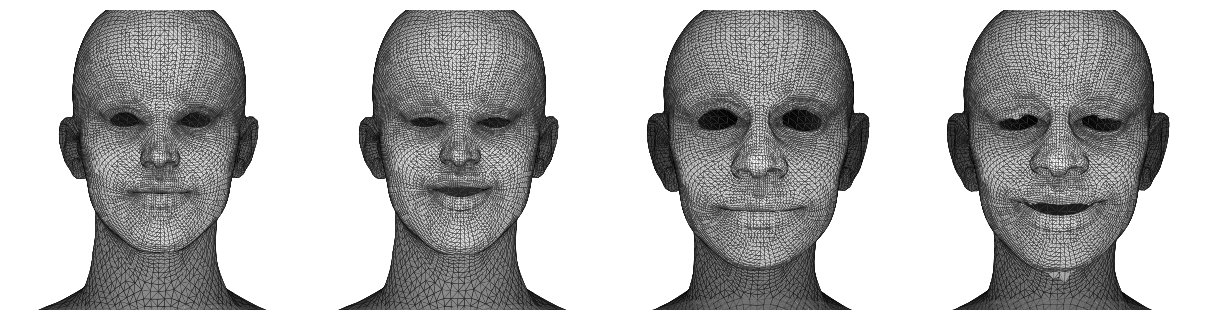

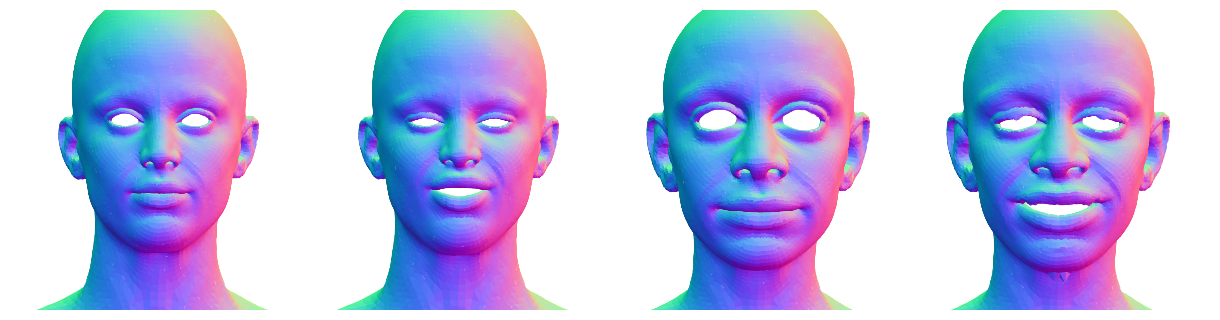

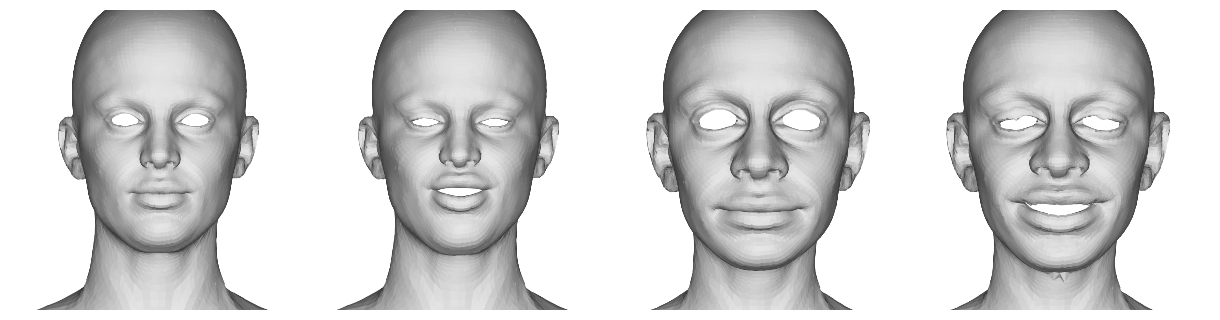

In [92]:
from matplotrender import *
# figure size
SIZE = 3

# mesh that you wanna render
FRAME=120
v_list=[ V, displacements[FRAME]+V, newV, new_displacements[FRAME]+newV ]
v_list=[v*0.8 for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')